# `DataPipeline2`

1. `Embarked`: Dropped NA rows and applied OneHotEncoding
2. `Age`: Mean imputation with SimpleImputer 
3. `Sex`: OneHotEncoding
4. `Name`: Categorised into ['Mr', 'Mrs', 'Miss', 'Master', 'Special']<br/> 
    5.1 Rename [Mlle, Ms] -> Miss      
    5.2 Rename [Mme] -> Mrs     
    5.3 Put the Rest -> other     
    Then performed OneHotEncoding
5. `Ticket`: categorized into [1: numeric, 0: else] <br/>
    6.1 Remove special characters but not space <br/>
    6.2 Replace numeric strings by 'numeric' <br/>
    6.3 Split on space and keep the first item <br/>
 Then applied binarizer for [1: numeric, 0: else]
6. `SibSp`: binned into [0, 1, >1] using SibSpBinner
7. `Parch`: binned into [0, 1, >1] using ParchBinner
8. Scaling all features at the last

**MLmodel:** `SVC`

In [1]:
import pandas as pd
import numpy as np
from src.utils import load_data
dfX, dfy = load_data(return_X_y=True)

In [3]:
from sklearn.pipeline import Pipeline
from src.preprocessing import NaNDropper

## `prepare`

In [4]:
prepare_data = Pipeline([
    ('nan_drpr', NaNDropper(['Embarked']))
])

dfX_pre, dfy_pre = prepare_data.fit_transform(dfX, dfy)

## `preprocess`

In [5]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn_pandas import DataFrameMapper

In [6]:
from src.featurization import NameTitleExtractor, CabinTypeExtractor, TicketTypeExtractor
from src.featurization import SibSpBinner, ParchBinner 

In [26]:

preprocess_noscale = ColumnTransformer([
    ('enc', OneHotEncoder(drop='first'), ['Sex', 'Embarked']),
    ('imp', SimpleImputer(), ['Age']),
    ('pre_Name', NameTitleExtractor(), 'Name'),
    ('pre_Cabin', CabinTypeExtractor(), 'Cabin'),
    ('pre_Ticket', TicketTypeExtractor(), 'Ticket'),
    ('Pre_SibSp', SibSpBinner(), ['SibSp']),
    ('Pre_Parch', ParchBinner(), ['Parch'])
], 
    'passthrough')

preprocess_data = Pipeline([
    ('clmn_trnsfrm', preprocess_noscale),
    ('scale', StandardScaler())
])

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.svm import SVC, LinearSVC

## `pipeline`

In [28]:
pipe = Pipeline([
    ('preprocess', preprocess_data),
    ('ml', SVC())
])
pipe.fit(dfX_pre, dfy_pre);

## training score

In [29]:
pipe.score(dfX_pre, dfy_pre)

0.8571428571428571

## Crossvalidation score

In [30]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
skf = StratifiedKFold(n_splits=5)
cross_val_score(pipe, dfX_pre, dfy_pre).mean()

0.8346854567383991

## Try various different ML models

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

In [32]:
from src.preprocessing import Passthrough

In [35]:
models = [
    RidgeClassifier(),
    LogisticRegression(solver="liblinear"),  # liblinear is better for small datasets
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=1),
    SVC(),
    RandomForestClassifier(random_state=1),
    BaggingClassifier(random_state=1)
]

param_grid = {'ml': [SVC()], 'preprocess__scale': [StandardScaler(), Passthrough()]}

In [36]:
grid_search = GridSearchCV(pipe, param_grid, cv=skf)
grid_search.fit(dfX_pre, dfy_pre);

In [37]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.8346854567383991
{'ml': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'preprocess__scale': StandardScaler(copy=True, with_mean=True, with_std=True)}


In [38]:
res = pd.DataFrame(grid_search.cv_results_)
res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml,param_preprocess__scale,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.044517,0.009092,0.018130,0.002114,"SVC(C=1.0, break_ties=False, cache_size=200, c...","StandardScaler(copy=True, with_mean=True, with...","{'ml': SVC(C=1.0, break_ties=False, cache_size...",0.848315,0.814607,0.837079,0.803371,0.870056,0.834685,0.023775,1
1,0.051776,0.019803,0.018315,0.000833,"SVC(C=1.0, break_ties=False, cache_size=200, c...",Passthrough(),"{'ml': SVC(C=1.0, break_ties=False, cache_size...",0.584270,0.713483,0.685393,0.685393,0.689266,0.671561,0.044885,2


[Text(0, 0, 'Scaling'), Text(0, 0, 'No Scaling')]

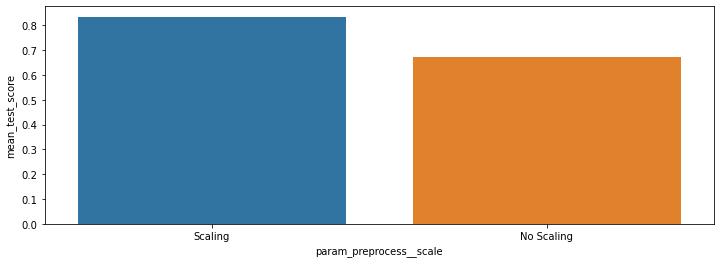

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
g = sns.barplot(x='param_preprocess__scale', y='mean_test_score', data=res)
g.set_xticklabels(['Scaling', 'No Scaling'])

In [ ]:
param_grid = {'ml': [KNeighborsClassifier()],
              'ml__n_neighbors': range(1, 11, 2),
              'ml__p': [1, 2, 3, 4],
              'preprocess__imp__strategy': ['median', 'mean'],
              'preprocess__Pre_SibSp': [Passthrough()]}